In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as mse

# Wine Quality Dataset Solution

## 1. Data Preprocessing

### 1.1 Reading the Dataset

- red wine quality data is read and stored in variable `winred`

In [35]:
winred  = pd.read_csv("winered.csv", delimiter = ";")
winred.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### 1.2 Exploratory Data Analysis 1
#### Missing Values Check

In [32]:
winred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
winetype                1599 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 162.5+ KB


** Comment:** No Missing variables present
#### Descriptive Statistics

In [21]:
winred.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


**Comment**:Scale of the Features vary, data needs to be standardized or normalized

#### 1D Outliers

In [240]:
print(f"There are {len(winred)} examples in this dataset")
winred_z_outlier = (winred - winred.mean())/winred.std()
winred_z_outlier = winred_z_outlier.where(winred_z_outlier<3 , 'outlier')
winred_z_outlier = winred_z_outlier.where(winred_z_outlier>-3 , 'outlier')
winred_z_outlier = (winred_z_outlier == 'outlier')
print(f"These are the number of datapoint in each feature outside 3 Standard Deviations from the mean\n")
print(winred_z_outlier.sum()[:-1])

rows_with_outliers = np.sum(winred_z_outlier.values[:,:-1],axis = 1)

There are 1599 examples in this dataset
These are the number of datapoint in each feature outside 3 Standard Deviations from the mean

fixed acidity           12
volatile acidity        10
citric acid              1
residual sugar          30
chlorides               31
free sulfur dioxide     22
total sulfur dioxide    15
density                 11
pH                       7
sulphates               27
alcohol                  8
dtype: int64


#### Pearson Correlation

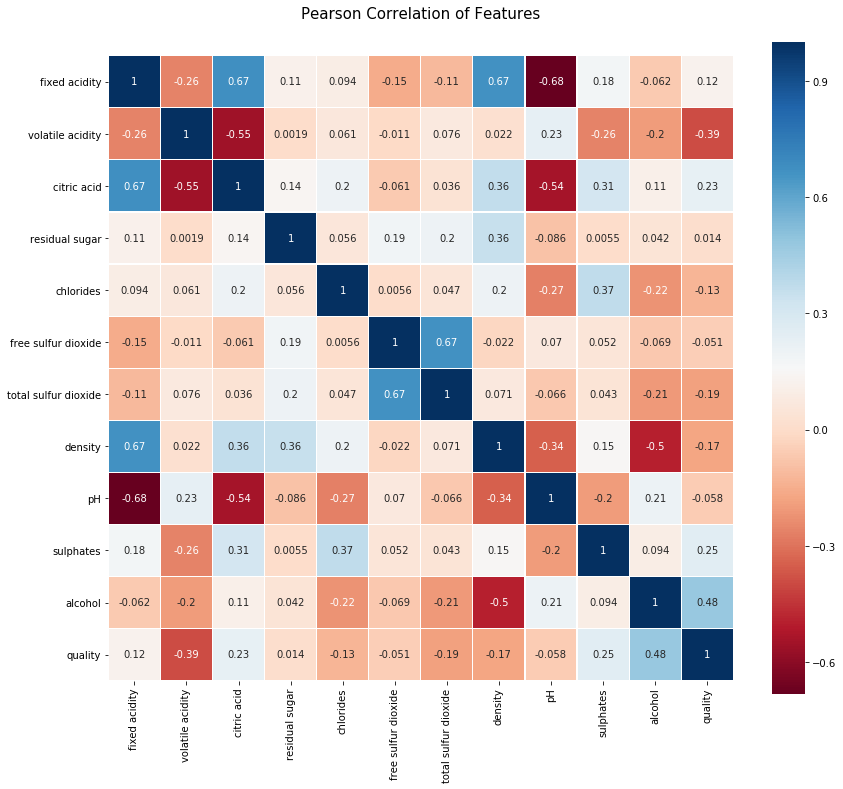

In [66]:
correlations = winred.corr()
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(correlations, linewidths = 0.1, vmax = 1, square = True, cmap = colormap, linecolor = 'white', annot = True)

**Comment:** No Feature is strongly correlated with `quality`, weak correlations exist with and  `alcohol` and `volatile acidity`
- *Could it be surmissed that higher alcohol strengths and lower volatile acidity provide indications of good wine quality?* 

#### Data Standardization and Train - Test Split (75:25)

In [228]:
winred_X = winred.iloc[:,:-1]
winred_y = winred.iloc[:,-1]
winred_standard_X = (winred_X - winred_X.mean())/winred_X.std()

X_train, X_test, y_train, y_test = train_test_split(
                            winred_standard_X.values, winred_y.values, test_size=0.25)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test:  {y_test.shape}\n")

#convert rows with outliers to zeros
winred_out_1D = (~rows_with_outliers.astype(bool)).reshape(-1,1) * winred_standard_X
#convert pandands dataframe to numpy
winred_out_1D = winred_out_1D.values
#select rows without outliers
winred_standard_X_out = winred_standard_X[np.all(winred_out_1D, axis = 1)]

winred_y_out = (~rows_with_outliers.astype(bool)) * winred_y.values
winred_y_out =  winred_y.values[(np.nonzero(winred_y_out)[0])]

X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
                            winred_standard_X_out, winred_y_out, test_size=0.25)

print(f"Shape of X_train_out: {X_train_out.shape}")
print(f"Shape of X_test_out:  {X_test_out.shape}")
print(f"Shape of y_train_out: {y_train_out.shape}")
print(f"Shape of y_test_out:  {y_test_out.shape}")

Shape of X_train: (1199, 11)
Shape of X_test:  (400, 11)
Shape of y_train: (1199,)
Shape of y_test:  (400,)

Shape of X_train_out: (1097, 11)
Shape of X_test_out:  (366, 11)
Shape of y_train_out: (1097,)
Shape of y_test_out:  (366,)


### 1.3 Base Line Models
Linear Regression models with :

**A)** With All Features <br>
**B)** With All Features without 1D outliers <br>
**C)** With `Alcohol` and `volatile acidity` 

In [229]:
reg = LR().fit(X_train,y_train)
rmse_prediction_A = mse(y_test,reg.predict(X_test))
print(f"RMSE with all features {np.sqrt(rmse_prediction_A)}")

reg = LR().fit(X_train_out,y_train_out)
rmse_prediction_B = mse(y_test_out,reg.predict(X_test_out))
print(f"RMSE with all features and without outliers {np.sqrt(rmse_prediction_A)}")

reg = LR().fit(X_train[:,[1,10]],y_train)
rmse_prediction_C = mse(y_test,reg.predict(X_test[:,[1,10]]))
print(f"RMSE with all Alcohol and Volatile Acidity {np.sqrt(rmse_prediction_C)}")

print("RMSE without outliers is better: ",rmse_prediction_B < rmse_prediction_A)
print("Absolute Difference between RMSE with and without outliers: ",np.abs(rmse_prediction_B-rmse_prediction_A))

RMSE with all features 0.663726418706897
RMSE with all features and without outliers 0.663726418706897
RMSE with all Alcohol and Volatile Acidity 0.6801616411294582
RMSE without outliers is better:  True
Absolute Difference between RMSE with and without outliers:  0.043438403642466705


**Conclusion:**
- Modelling will proceed with all examples because of small size of dataset and the oultiers donot impact the RMSE significantly